In [18]:
%pip install seaborn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
import csv
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from collections import defaultdict
from calendar import monthrange
from datetime import datetime, timedelta
import matplotlib.lines as mlines

In [20]:
# Landers
lndNames = ["LND-Mars-lat0", "LND-Mars-lat30", "LND-Mars-lat60", "LND-Mars-lat90"]
lndNames_lat = [0, 30, 60, 90]

# Orbiters
alts = [100, 500, 900, 1300] # Altitudes
incs = [0  , 30 , 60 , 90  ] # Inclination

In [21]:
# Load data from files
data = {lndName: {alt: {inc: [] for inc in incs} for alt in alts} for lndName in lndNames}
for lndName in lndNames:
    for alt in alts:
        for inc in incs:

            # filename
            satName = "SAT-Mars-alt{}-inc{}".format(alt, inc)
            file_name = "access_int_1_{}_to_{}.csv".format(lndName, satName)

            # load file
            with open(file_name, newline='') as csvfile:
                reader = csv.reader(csvfile)
                data_started = False
                
                for row in reader:
                    
                    # skip header
                    if not data_started:
                        if row and row[0].startswith('Access'):
                            data_started = True
                    else:
                        # load line
                        data[lndName][alt][inc].append(row)

In [22]:
# Function to convert EpSec to datetime
def convert_epsec_to_datetime(epsec):
    start_date = datetime(2025, 1, 1)
    return start_date + timedelta(seconds=epsec)

# Speed of light in km/s
speed_of_light = 299792

In [23]:
# Plots
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
line_styles = ['-', '--', '-.', ':']

# Plots
sns.set()
palette = sns.color_palette()

# Contact Duration

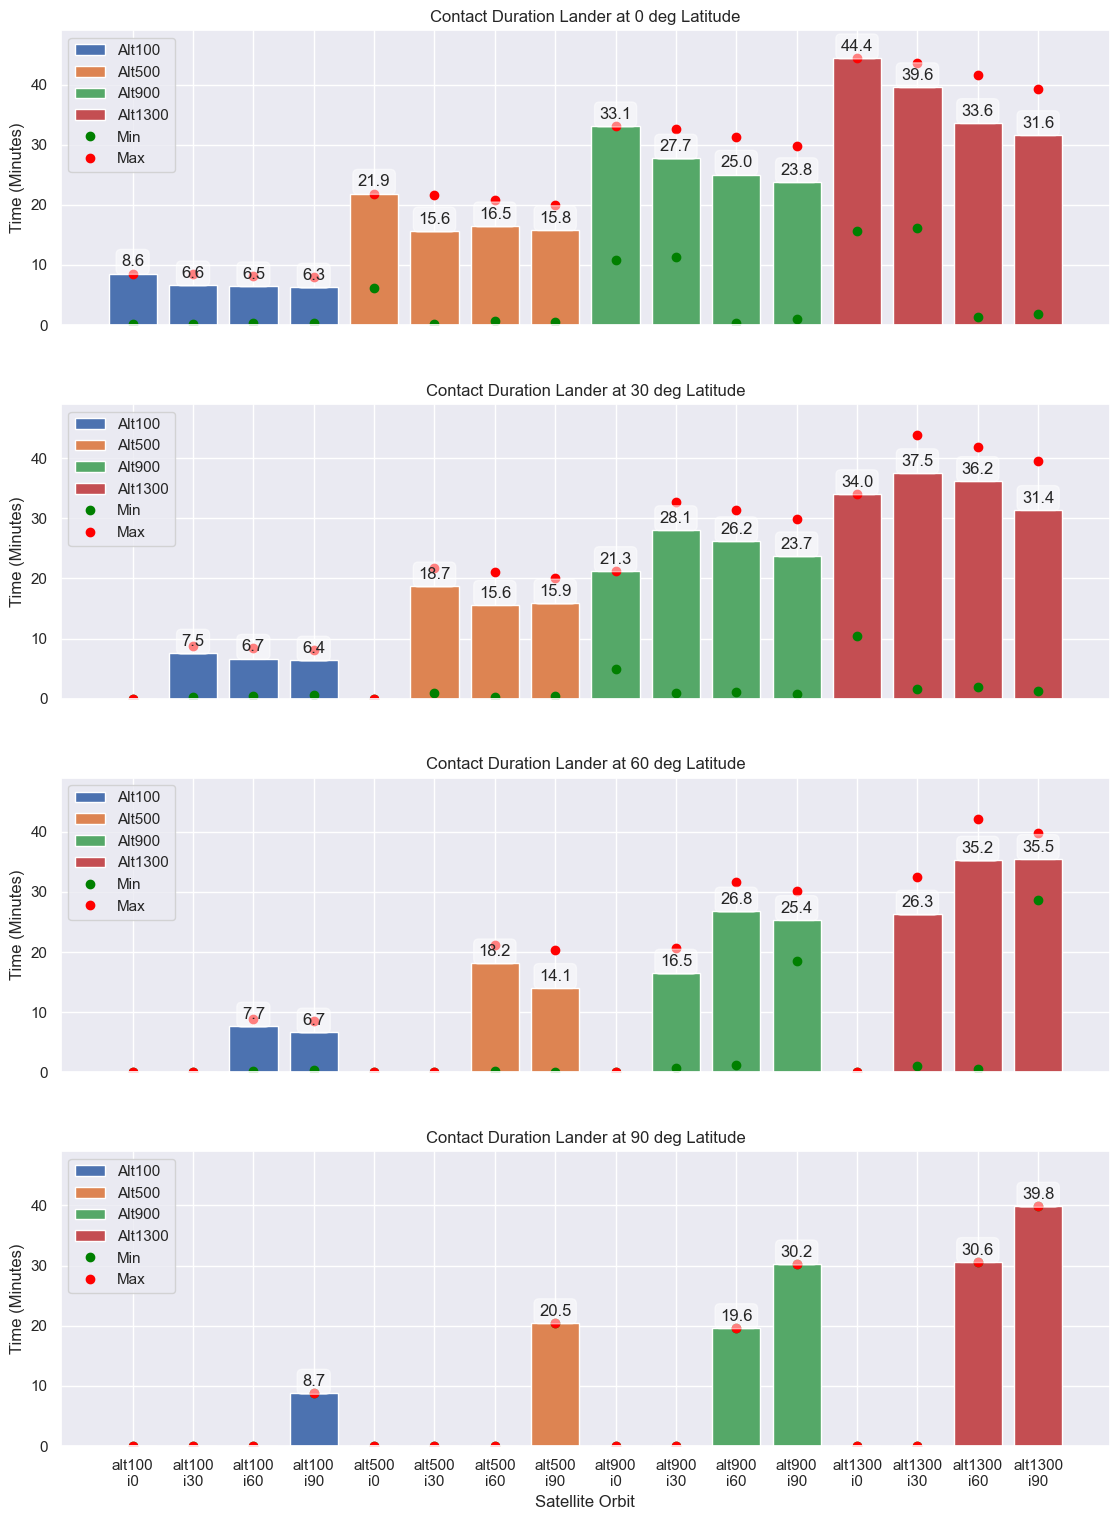

In [24]:
# Function to calculate statistics for revisit times
def calculate_revisit_stats(data):
    stats = {}
    for lndName in data:
        for alt in data[lndName]:
            for inc in data[lndName][alt]:
                times = [float(row[3]) for row in data[lndName][alt][inc]]  # Duration is the 4th column
                if times:  # Check if the list is not empty
                    avg_time = sum(times) / len(times)
                    min_time = min(times)
                    max_time = max(times)

                    avg_time = avg_time / 60 # to Minutes
                    min_time = min_time / 60 # to Minutes
                    max_time = max_time / 60 # to Minutes

                    stats[(lndName, alt, inc)] = (avg_time, min_time, max_time)
                else:
                    stats[(lndName, alt, inc)] = (0, 0, 0)

    return stats

# Calculate statistics
revisit_stats = calculate_revisit_stats(data)

# Creating custom legend handles for Min and Max
min_handle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', label='Min')
max_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Max')

# Creating subplots for each lander
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16), sharex=True)
fig.tight_layout(pad=6.0)

for idx, lndName in enumerate(lndNames):
    for alt_idx, alt in enumerate(alts):
        x = []
        y_avg = []
        y_min = []
        y_max = []
        for inc in incs:
            key = (lndName, alt, inc)
            if key in revisit_stats:
                avg_time, min_time, max_time = revisit_stats[key]
                #x.append(f"a{alt}\ni{inc}")
                x.append(f"alt{alt}\ni{inc}")
                y_avg.append(avg_time)
                y_min.append(min_time)
                y_max.append(max_time)

        # Plotting for each lander and altitude
        ax = axes[idx]
        bars = ax.bar(x, y_avg, color=palette[alt_idx], label=f'Alt{alt}')
        ax.scatter(x, y_min, color='green')
        ax.scatter(x, y_max, color='red')
        ax.set_ylim(0, 49)

        # Annotate the bars
        for bar in bars:
            bar_height = bar.get_height()
            if bar_height > 0:  # Only annotate if y_avg is higher than zero
                ax.annotate(f'{bar_height:.1f}',
                            xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5))

    ax.set_title(f"Contact Duration Lander at {lndNames_lat[idx]} deg Latitude")
    ax.set_ylabel("Time (Minutes)")

    # Add the custom handles to the legend
    handles, labels = ax.get_legend_handles_labels()
    # Add custom handles for Min and Max at the end
    handles.extend([min_handle, max_handle])
    ax.legend(handles=handles)

# X label only in the last plot
ax.set_xlabel("Satellite Orbit")

file_name = "stk-mars-revisit-contact-duration"
fig.savefig(file_name + '.png', dpi=300)  
fig.savefig(file_name + '.pdf')  

fig.tight_layout(pad=3.0)
plt.show()


# Contact Gap

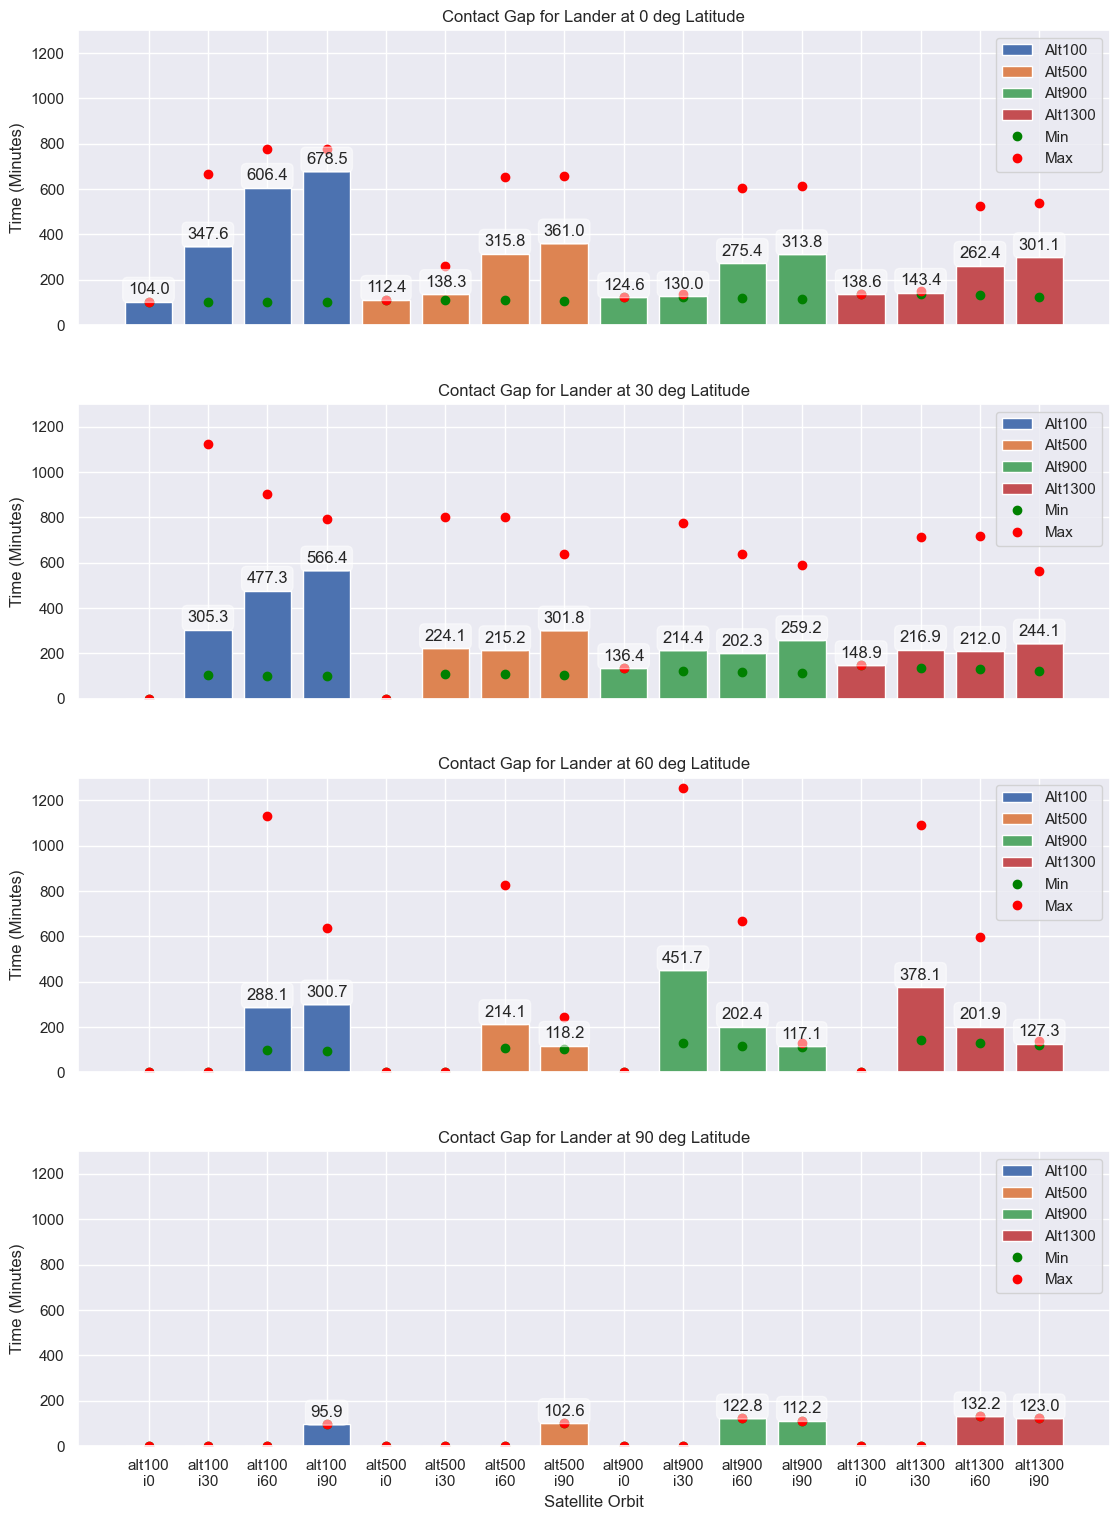

In [25]:
def calculate_contact_gap_stats(data):
    gap_stats = {}
    for lndName in data:
        for alt in data[lndName]:
            for inc in data[lndName][alt]:
                start_times = [float(row[1]) for row in data[lndName][alt][inc]]  # startTime[EpSec] is the 2nd column
                end_times = [float(row[2]) for row in data[lndName][alt][inc]]
                if len(start_times) > 1:  # Need at least two contacts to calculate a gap
                    # Calculate the gaps by subtracting consecutive start times
                    gaps = [start_times[i+1] - end_times[i] for i in range(len(start_times) - 1)]
                    avg_gap = sum(gaps) / len(gaps)
                    min_gap = min(gaps)
                    max_gap = max(gaps)

                    avg_gap = avg_gap / 60  # to Minutes
                    min_gap = min_gap / 60  # to Minutes
                    max_gap = max_gap / 60  # to Minutes

                    gap_stats[(lndName, alt, inc)] = (avg_gap, min_gap, max_gap)
                else:
                    # No gaps if there are fewer than two contacts
                    gap_stats[(lndName, alt, inc)] = (0, 0, 0)
    return gap_stats

# Calculate statistics
gap_stats = calculate_contact_gap_stats(data)

# Creating custom legend handles for Min and Max
min_handle = mlines.Line2D([], [], color='green', marker='o', linestyle='None', label='Min')
max_handle = mlines.Line2D([], [], color='red', marker='o', linestyle='None', label='Max')

# Creating subplots for each lander
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 16), sharex=True)
fig.tight_layout(pad=6.0)

for idx, lndName in enumerate(lndNames):
    for alt_idx, alt in enumerate(alts):
        x = []
        y_avg = []
        y_min = []
        y_max = []
        for inc in incs:
            key = (lndName, alt, inc)
            if key in gap_stats:
                avg_time, min_time, max_time = gap_stats[key]
                #x.append(f"a{alt}\ni{inc}")
                x.append(f"alt{alt}\ni{inc}")
                y_avg.append(avg_time)
                y_min.append(min_time)
                y_max.append(max_time)

        # Plotting for each lander and altitude
        ax = axes[idx]
        bars = ax.bar(x, y_avg, color=palette[alt_idx], label=f'Alt{alt}')
        ax.scatter(x, y_min, color='green')
        ax.scatter(x, y_max, color='red')
        ax.set_ylim(0, 1300)

        # Annotate the bars
        for bar in bars:
            bar_height = bar.get_height()
            if bar_height > 0:  # Only annotate if y_avg is higher than zero
                ax.annotate(f'{bar_height:.1f}',
                            xy=(bar.get_x() + bar.get_width() / 2, bar_height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom',
                            bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.5))

    ax.set_title(f"Contact Gap for Lander at {lndNames_lat[idx]} deg Latitude")
    ax.set_ylabel("Time (Minutes)")

    # Add the custom handles to the legend
    handles, labels = ax.get_legend_handles_labels()
    # Add custom handles for Min and Max at the end
    handles.extend([min_handle, max_handle])
    ax.legend(handles=handles)

# X label only in the last plot
ax.set_xlabel("Satellite Orbit")

fig.tight_layout(pad=3.0)

file_name = "stk-mars-revisit-contact-gap"
fig.savefig(file_name + '.png', dpi=300)  
fig.savefig(file_name + '.pdf')  

plt.show()
